In [1]:
# Importações

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
)
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay


# Algoritmos de classificação

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm import SVC

from sklearn.neighbors import KNeighborsClassifier


from imblearn.over_sampling import RandomOverSampler

import joblib


from src.config import (
    CLEANED_DATA_FILEPATH,
    FINAL_MODEL_FILEPATH
)
from src.models import (
    train_validate_classificator,
    grid_search_classificator
)
from src.graphics import plot_comparing_metrics
from src.utils import organize_results

In [2]:
# Obtendo os dados como DataFrame
df = pd.read_parquet(CLEANED_DATA_FILEPATH)
df.head()

,rotulo,FOS_FOS_Variance,FOS_FOS_Median,FOS_FOS_Mode,FOS_FOS_MinimalGrayLevel,FOS_FOS_10Percentile,FOS_FOS_25Percentile,FOS_FOS_75Percentile,FOS_FOS_90Percentile,FOS_FOS_HistogramWidth,...,cor_G_min,cor_G_mediana,cor_B_min,cor_B_mediana,tex_gradiente_std,tex_gradiente_max,tex_laplacian_media,tex_suavidade,comp_variancia_blocos,comp_media_blocos
0,manipulado,310.826241,non_zero,non_zero,non_zero,non_zero,non_zero,non_zero,non_zero,non_zero,...,non_zero,non_zero,non_zero,non_zero,59.640702,813.904171,3.545090,0.996780,9.247067,2.752584
1,manipulado,423.482420,zero,zero,zero,zero,zero,zero,zero,zero,...,zero,zero,zero,zero,85.818398,1001.784408,4.946321,0.997635,13.897900,3.541544
2,manipulado,3412.467306,zero,zero,zero,zero,zero,non_zero,non_zero,non_zero,...,zero,zero,zero,zero,92.008275,1066.317026,5.399804,0.999706,15.709027,4.631431
3,manipulado,372.246170,zero,zero,zero,zero,zero,zero,zero,zero,...,zero,zero,zero,zero,82.538567,982.231134,4.582021,0.997310,13.599282,3.397348
4,manipulado,3414.554278,zero,zero,zero,zero,zero,non_zero,non_zero,non_zero,...,zero,zero,zero,zero,94.192267,1067.064197,5.576363,0.999706,16.027229,4.811873


In [3]:
# Resumo da base
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   rotulo                    194 non-null    object 
 1   FOS_FOS_Variance          194 non-null    float64
 2   FOS_FOS_Median            194 non-null    object 
 3   FOS_FOS_Mode              194 non-null    object 
 4   FOS_FOS_MinimalGrayLevel  194 non-null    object 
 5   FOS_FOS_10Percentile      194 non-null    object 
 6   FOS_FOS_25Percentile      194 non-null    object 
 7   FOS_FOS_75Percentile      194 non-null    object 
 8   FOS_FOS_90Percentile      194 non-null    object 
 9   FOS_FOS_HistogramWidth    194 non-null    object 
 10  GLCM_GLCM_ASM_Mean        194 non-null    float64
 11  cor_R_mediana             194 non-null    object 
 12  cor_G_min                 194 non-null    object 
 13  cor_G_mediana             194 non-null    object 
 14  cor_B_min 

In [4]:
# Separação em X e y

X = df.drop("rotulo", axis=1)
y = df["rotulo"]

In [5]:
# Codificação para números de y

le = LabelEncoder()
y = le.fit_transform(y)

y[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [6]:
le.classes_

array(['autentico', 'manipulado'], dtype=object)

In [7]:
# Fixando seed de aleatoriedade
RANDOM_STATE = 42

In [8]:
# Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=RANDOM_STATE, stratify=y
)

In [9]:
# Definição do cross validator
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [10]:
# Definição das transformações no preprocessamento de cada coluna

std_columns = df.select_dtypes("number").columns.to_list()

ohe_columns = df.columns.drop("rotulo").difference(std_columns).to_list()

In [11]:
# Definição dos preprocessamentos

preprocessing = ColumnTransformer(
    [
        ("ohe", OneHotEncoder(drop="first"), ohe_columns),
        ("std", StandardScaler(), std_columns),
    ]
)

tree_preprocessing = ColumnTransformer(
    [
        ("ohe", OneHotEncoder(drop="first"), ohe_columns),
    ],
    remainder="passthrough",
)

In [12]:
# Definição do hiperparametro scale_pos_weight
scale_pos_weight = np.bincount(y)[0] / np.bincount(y)[1]

In [13]:
# Definição do PCA
pca = PCA(n_components=3, random_state=RANDOM_STATE)

In [14]:
# Definição do sampler
sampler = RandomOverSampler(random_state=RANDOM_STATE)

In [15]:
# Obtendo reamostragem dos dados
X_ros, y_ros = sampler.fit_resample(X_train, y_train)
np.bincount(y_ros)

array([141, 141])

In [16]:
# Definição dos classificadores

classificators = {
    "DummyClassifier": {
        "preprocessing": None,
        "pca": None,
        "classificator": DummyClassifier(strategy="stratified"),
    },
    "LogisticRegression": {
        "preprocessing": preprocessing,
        "pca": pca,
        "classificator": LogisticRegression(class_weight="balanced", random_state=RANDOM_STATE),
    },
    "DecisionTreeClassifier": {
        "preprocessing": tree_preprocessing,
        "pca": None,
        "classificator": DecisionTreeClassifier(class_weight="balanced",  random_state=RANDOM_STATE),
    },
    "XGBClassifier": {
        "preprocessing": tree_preprocessing,
        "pca": None,
        "classificator": XGBClassifier(
            scale_pos_weight=scale_pos_weight,
            n_jobs=-1,
            random_state=RANDOM_STATE,
            ),
    },
    "LGBMClassifier": {
        "preprocessing": tree_preprocessing,
        "pca": None,
        "classificator": LGBMClassifier(
            scale_pos_weight=scale_pos_weight,
            n_jobs=-1,
            verbose=-1,
            random_state=RANDOM_STATE,
        ),
    },
    "SVC": {
        "preprocessing": preprocessing,
        "pca": pca,
        "classificator": SVC(
            class_weight="balanced", 
            random_state=RANDOM_STATE
            )
    },
    "KNeighborsClassifier": {
        "preprocessing": preprocessing,
        "pca": pca,
        "classificator": KNeighborsClassifier(),
    },
}

In [17]:
# Aplicando validação cruzada para cada classificador

results = {
    name: train_validate_classificator(X_ros, y_ros, kf, **classificator)
    for name, classificator in classificators.items()
}

df_results = organize_results(results)
df_results

/home/lucas/Documentos/python/screenshot_validation/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lucas/Documentos/python/screenshot_validation/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lucas/Documentos/python/screenshot_validation/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lucas/Documentos/python/screenshot_validation/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/lucas/Documentos/python/screenshot_validation/venv

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
0,DummyClassifier,0.00311,0.019363,0.526316,0.527709,0.557377,0.515152,0.607143,0.491995,0.487287,0.022473
1,DummyClassifier,0.001548,0.009739,0.54386,0.544335,0.535714,0.555556,0.517241,0.524015,0.521224,0.011287
2,DummyClassifier,0.001345,0.008102,0.535714,0.535714,0.458333,0.55,0.392857,0.375,0.453704,0.009448
3,DummyClassifier,0.001577,0.010619,0.517857,0.517857,0.490566,0.52,0.464286,0.535714,0.519133,0.012196
4,DummyClassifier,0.001892,0.00662,0.553571,0.553571,0.545455,0.555556,0.535714,0.553571,0.53,0.008512
5,LogisticRegression,0.014628,0.019219,0.508772,0.50431,0.333333,0.5,0.25,0.45936,0.564463,0.033847
6,LogisticRegression,0.014935,0.020121,0.614035,0.620074,0.421053,0.888889,0.275862,0.689655,0.74677,0.035057
7,LogisticRegression,0.013846,0.020175,0.625,0.625,0.4,1.0,0.25,0.579082,0.669919,0.034022
8,LogisticRegression,0.01376,0.020328,0.660714,0.660714,0.486486,1.0,0.321429,0.605867,0.725244,0.034088
9,LogisticRegression,0.014188,0.021667,0.625,0.625,0.432432,0.888889,0.285714,0.55102,0.668128,0.035854


In [18]:
# Agrupando as métricas de cada modelo, em cada iteração, pela média
df_results.groupby("model").mean().sort_values("test_f1", ascending=True)

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
SVC,0.009954,0.015782,0.631328,0.631158,0.413279,1.0,0.262315,0.614646,0.711906,0.025736
LogisticRegression,0.014271,0.020302,0.606704,0.60702,0.414661,0.855556,0.276601,0.576997,0.674905,0.034573
DummyClassifier,0.001894,0.010889,0.535464,0.535837,0.517489,0.539253,0.503448,0.496059,0.502269,0.012783
KNeighborsClassifier,0.008707,0.015334,0.681015,0.681404,0.627285,0.758077,0.539409,0.714598,0.758937,0.024041
LGBMClassifier,0.040746,0.020556,0.790977,0.791133,0.737874,0.977778,0.596059,0.855775,0.894535,0.061303
XGBClassifier,0.05816,0.019031,0.81203,0.812192,0.770173,0.980952,0.638177,0.861612,0.903346,0.07719
DecisionTreeClassifier,0.011173,0.01802,0.865351,0.865271,0.843752,0.980952,0.744335,0.865271,0.859041,0.029192


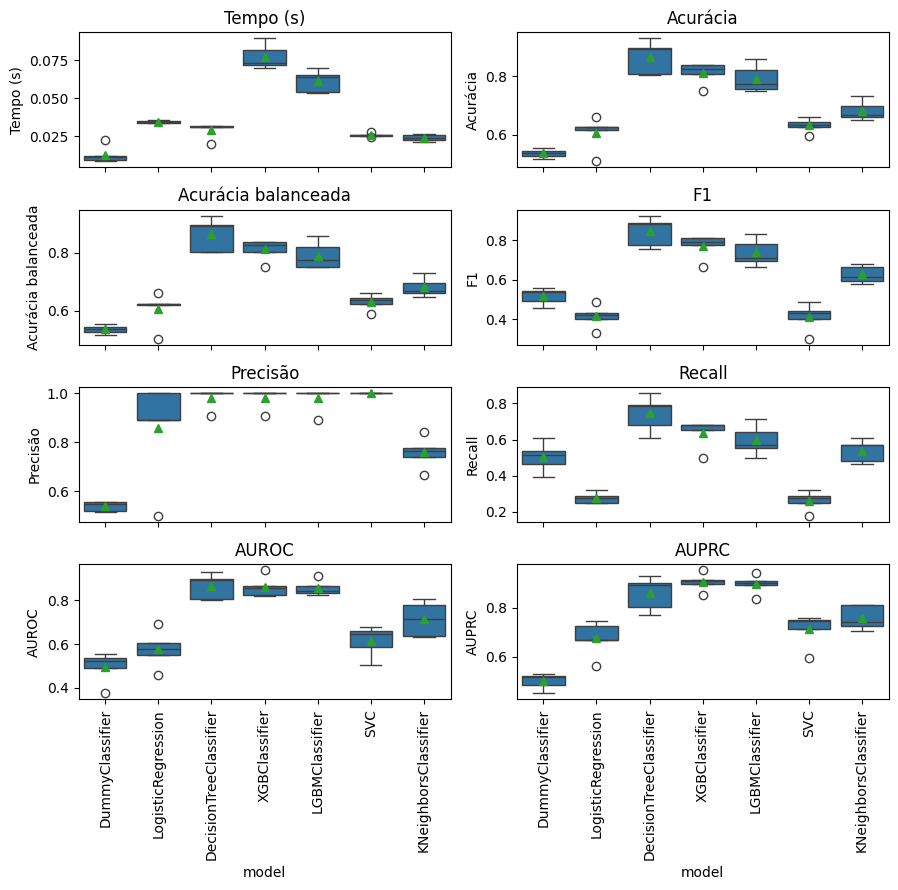

In [19]:
# Boxplots das métricas
plot_comparing_metrics(df_results)

In [20]:
# Definição da grade de parâmetros

param_grid = {
    "clf__criterion": ["gini", "entropy"],
    "clf__max_depth": [None, 3, 5, 7, 10],
}
param_grid

{'clf__criterion': ['gini', 'entropy'], 'clf__max_depth': [None, 3, 5, 7, 10]}

In [21]:
# Definição do grid search

grid_search = grid_search_classificator(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    tree_preprocessing,
    param_grid,
    kf,
    refit_metric="f1",
)

grid_search.fit(X_ros, y_ros)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'clf__criterion': ['gini', 'entropy'], 'clf__max_depth': [None, 3, ...]}"
,scoring,"['accuracy', 'balanced_accuracy', ...]"
,n_jobs,1
,refit,'f1'
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('ohe', ...)]"


In [22]:
# Melhor estimador
grid_search.best_estimator_

,steps,"[('preprocessing', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('ohe', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [23]:
# Melhores parametros
grid_search.best_params_

{'clf__criterion': 'gini', 'clf__max_depth': None}

In [24]:
# Melhor pontuação de f1_score
grid_search.best_score_

np.float64(0.8348285365428222)

In [25]:
grid_search.best_estimator_.named_steps

{'preprocessing': ColumnTransformer(remainder='passthrough',
                   transformers=[('ohe', OneHotEncoder(drop='first'),
                                  ['FOS_FOS_10Percentile',
                                   'FOS_FOS_25Percentile',
                                   'FOS_FOS_75Percentile',
                                   'FOS_FOS_90Percentile',
                                   'FOS_FOS_HistogramWidth', 'FOS_FOS_Median',
                                   'FOS_FOS_MinimalGrayLevel', 'FOS_FOS_Mode',
                                   'cor_B_mediana', 'cor_B_min', 'cor_G_mediana',
                                   'cor_G_min', 'cor_R_mediana'])]),
 'clf': DecisionTreeClassifier(random_state=42)}

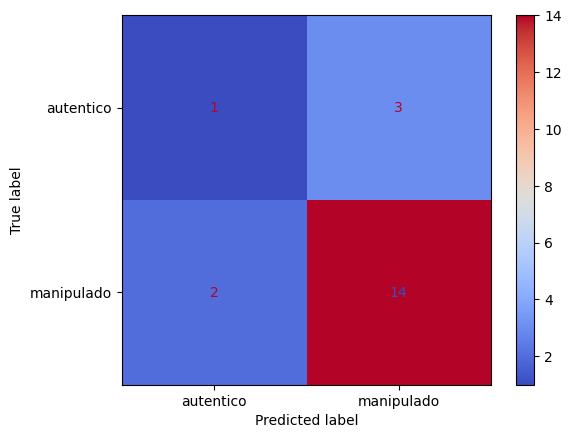

In [26]:
# Matriz de confusão

ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X_test,
    y_test,
    display_labels=le.classes_,
    cmap="coolwarm",
)

plt.show()

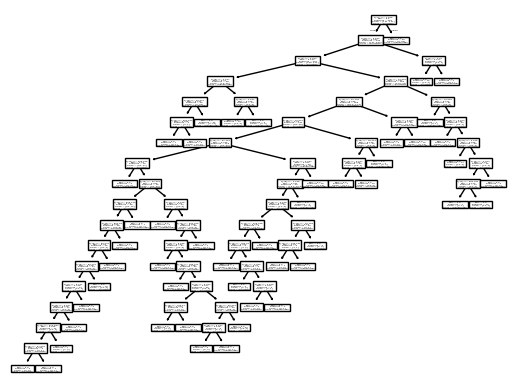

In [27]:
# Verificando a estrutura da árvore

plot_tree(
    grid_search.best_estimator_["clf"],
    class_names=le.classes_
)

plt.show()

In [28]:
# Salvando modelo
joblib.dump(
    grid_search.best_estimator_,
    FINAL_MODEL_FILEPATH
)

['/home/lucas/Documentos/python/screenshot_validation/models/decision_tree_preprocessing.joblib']